https://github.com/ogrisel/sklearn_pycon2014/blob/master/notebooks/06_validation.ipynb

# Validation and Model Selection

- Section goes into depth on how to evaluate and improve a training of a supervised classification or regression model
    - Covers: 
        - Several Metrics Used to Evaluate Model Performance
        - Know the Difference Between Bias and Variance, and the Tradeoff
        - Know How to Use Cross Validation Curves to Evaluate and Improve Your Model
        - Know How to Use Learning Curves to Further Evaluate and Improve Your Model 
        
        
# Exploring Validation Metrics
- Evaluate Perform of Models By:
    - Count the Number of Mis-Matches (Not Always Sufficient)
    - Example: Identify a Rare Class of Event From Within a Large Number of Background Sources (Find Varying Stars From In Background of Non-varying Stars)


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 

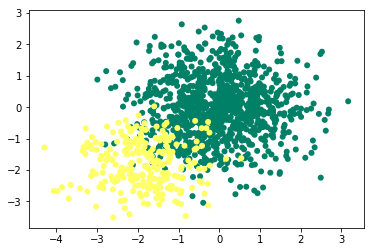

In [2]:
# Create Unbalanced 2D Dataset
np.random.seed(0)
X = np.vstack([np.random.normal(0, 1, (1000, 2)), # 1000 Points of Non-Varying Data
               np.random.normal(-1.8, 0.8, (250, 2))]) # 250 Points of Varying Data 
# Stacks 1000 Non-Varying Data With 250 Varying Data (1250 x 2)

# Vstack: Take A Sequence Of Arrays And Stack Them Vertically To Make A Single Array.

target = np.hstack([np.zeros(1000), np.ones(250)])
# Create 1000 Targets Equaling 0
# Create  200 Targets Equaling 1
# Take A Sequence Of Arrays And Stack Them Horizontally To Make A Single Array. (1250 Rows)

plt.scatter(X[:, 0], X[:, 1], c = target, edgecolors='none', cmap=plt.cm.summer);

# Exercise 1: Validation
- Use a Support Vector Machine to See How Well the Model Classifies the Data

/Users/kerrylam/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy: 93.2907348243 %
Precision: 94.3396226415 %
Recall: 73.5294117647 %
f1 score: 82.6446280992 %


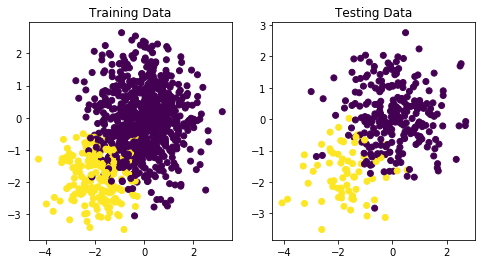

In [3]:
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split 
from sklearn import metrics

# Instantiate Model 
clf = SVC()

# Split Data into Training and Testing Set
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size = 0.25, random_state = 0)

# Fit Data
clf.fit(X_train, target_train)

# Predict Labels of Test Data
target_pred = clf.predict(X_test)

# Predict Measures On the Model's Prediction
print ("Accuracy:", metrics.accuracy_score(target_test, target_pred)*100, "%")
print ("Precision:", metrics.precision_score(target_test, target_pred)*100, "%")
print ("Recall:", metrics.recall_score(target_test, target_pred)*100, "%")
print ("f1 score:", metrics.f1_score(target_test, target_pred)*100, "%")


# Create 1 x 2 Figure (1 Row, 2 Plots)
fig, plot = plt.subplots(1, 2, figsize=(8, 4))
plt.title("Training Set")
          
plot[0].scatter(X_train[:,0] , X_train[:,1] , c = target_train)
plot[0].title.set_text('Training Data')

plot[1].scatter(X_test[:,0] , X_test[:,1] , c = target_test)
plot[1].title.set_text('Testing Data')

#### Problem With Simple Validation
- We might not care about how well we classify the background, but instead be concerned with successfully pulling out an uncontaminated set of foreground sources
- Solve this by computing statistics for precision, recall and f1 score 

# Interpretation: 

$$ 
{\rm accuracy} \equiv \frac{\rm correct~labels}{\rm total~samples} $$$$ 
{\rm precision} \equiv \frac{\rm true~positives}
{\rm true~positives + false~positives} $$$$ {\rm recall} \equiv \frac{\rm true~positives}
{\rm true~positives + false~negatives} $$$$ F_1 \equiv 2 \frac{\rm precision \cdot recall}{\rm precision + recall} $$

The accuracy, precision, recall, and f1-score all range from 0 to 1, with 1 being optimal. Here we've used the following definitions:
- True Positives are those which are labeled 1 which are actually 1.
     - Apply True (Correct) Label When Classification Is True (Correct)
- False Positives are those which are labeled 1 which are actually 0.
     - Apply True (Correct) Label When Classification Was False (Incorrect)
- True Negatives are those which are labeled 0 which are actually 0.
     - Apply False (Incorrect) Label When Classification Was False (Incorrect)
- False Negatives are those which are labeled 0 which are actually 1.
     - Apply False (Incorrect) Label When Classification Was True (Correct)

In [4]:
print (metrics.classification_report(target_test, target_pred, target_names = ['Background', 'Foreground']))

             precision    recall  f1-score   support

 Background       0.93      0.99      0.96       245
 Foreground       0.94      0.74      0.83        68

avg / total       0.93      0.93      0.93       313



# Interpreting Metrics

- Overall Correct Classification Rate: 93%
- Correctly Identified: 74%
- Labeled as Positives: 94%

# Exercise 2 
- Compare Accuracy, Precision, and Recall On: 
    - K Neighbors Classifier
    - Gaussian Naive Bayes Class
    - Support Vector Machine Classifier

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Fit Your Training and Target Data Into i Classifier 
for classifier in [KNeighborsClassifier, GaussianNB, SVC]:
    cls = classifier().fit(X_train, target_train)
    target_pred = cls.predict(X_test)
    print("-----------------------------------------------------")
    # __name__ Method Prints Out Name of Classifier 
    print(classifier.__name__)
    print(metrics.classification_report(target_pred, target_test))

-----------------------------------------------------
KNeighborsClassifier
             precision    recall  f1-score   support

        0.0       0.98      0.93      0.95       260
        1.0       0.72      0.92      0.81        53

avg / total       0.94      0.93      0.93       313

-----------------------------------------------------
GaussianNB
             precision    recall  f1-score   support

        0.0       0.99      0.93      0.96       261
        1.0       0.72      0.94      0.82        52

avg / total       0.94      0.93      0.93       313

-----------------------------------------------------
SVC
             precision    recall  f1-score   support

        0.0       0.99      0.93      0.96       260
        1.0       0.74      0.94      0.83        53

avg / total       0.95      0.93      0.94       313



# Using Cross Validation 
- Disadvantage of Train/Test Split is Fitting Only a Portion of the Dataset
`Cross Validation Involves Running Two Trials, Where You Split the Data into Two Sets and Train on the First Set, and then Train a Second Time on the Second Set

In [6]:
# Split Dataset in Half
set_1, set_2, target_1, target_2 = train_test_split(X, target, test_size = 0.5)
print (set_1.shape)
print (set_2.shape)

(625, 2)
(625, 2)


In [7]:
# Fit First Set of Data to Predict Set 2
target_1_prediction = SVC().fit(set_1, target_1).predict(set_2)
# Fit Second Set of Data to Predict Set 1
target_2_prediction = SVC().fit(set_2, target_2).predict(set_1)

# Calculate Mean of Predicted Set and Actual Target
print (np.mean([metrics.precision_score(target_1, target_1_prediction),
               metrics.precision_score(target_2, target_2_prediction)]))

0.233309378369


# Two-Fold Cross-Validation
    - Special Case Of K-Fold Cross Validation
        - sklearn.cross_validation.KFold 
        - sklearn.cross_validation.StratifiedKFold

In [8]:
from sklearn.cross_validation import cross_val_score
# 2-fold cross-validation of the SVC estimator
print (cross_val_score(SVC(), X, target, cv=2, scoring = 'precision'))

[ 0.86290323  0.89473684]


# Exercise 3
- The SVC classifier takes a parameter C whose default value is 1. 
- Using 5-fold cross-validation, make a plot of the precision as a function of C, for the SVC estimator on this dataset
- In k-fold Cross Validation, where the original sample is randomly split into k equal sized subsamples. 
    - Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k-1 subsamples are used as training data.
    - The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data.
        - (e.g. Subset 1 used as validation and the other 4 subsets are used as training data)
        - (e.g. Subset 2 used as validation and the other 4 subsets are used as training data)
        - (e.g. Continue with other subsets)

[0.96666666666666656, 0.91545921121496343, 0.88995285365737686, 0.88455289327382347, 0.87989101541733117, 0.88531466129814884, 0.88462954930868898, 0.88561801839153209, 0.88179372898584718, 0.8752494435884266]


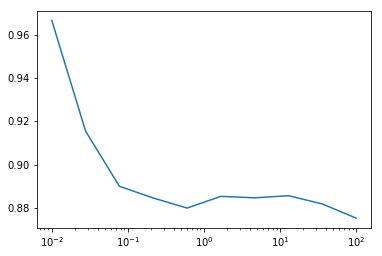

In [9]:
# Plot of Precision as a Function of C 
# np.logspace(Start, Stop, Number of Samples to Generate) ~ Given in Base 10 
C = np.logspace(-2, 2, 10)

"""?"""
scores = [cross_val_score(SVC(C=Ci), X, target, cv = 5, scoring='precision').mean() for Ci in C]
plt.semilogx(C, scores);
print(scores)

# Grid Search
- Grid Search Used for Model Evaluation to Find Best Parameter Choice (C)
- GridSearchCV has a fit method: it is a meta-estimator: an estimator over estimators
- Grid search can come in very handy when you're tuning a model for a particular task

In [10]:
"""Evaluate Trained Models Using Cross-Validation Where Different Models With Its Own Parameter Values Lie on a Grid"""
from sklearn.grid_search import GridSearchCV
clf = SVC()
# np.logspace(Start, Stop, Number of Samples to Generate = 40) ~ Given in Base 10 
# Create Range of Possible C Parameters
C_range = np.logspace(-2, 2, 100)


"""
GridSearchCV Parameters (Has Its Own Fit Method)
1) Model used to Grid Search (e.g. SVC())
2) Parameter Grid (Values from C_range)
3) Scoring Method: Precision
4) 5 Fold Cross Validate (Validate 5 Times) 
5) Fit (X, target)
"""
grid = GridSearchCV(clf, 
                    param_grid = {'C': C_range},
# param_grid Creates a Dictionary With Parameter Name and Parameter String to Enable Searching Over Sequence
                    scoring = 'precision', 
                    cv = 5)
grid.fit(X, target)
print ("Best Parameter Choice:", grid.best_params_)

/Users/kerrylam/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Best Parameter Choice: {'C': 0.010974987654930561}


'Plot the Score of Each Parameter Used in the Validated Models'

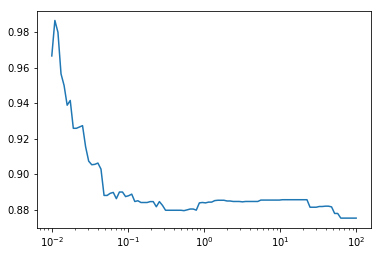

In [11]:
scores = [g[1] for g in grid.grid_scores_]
plt.semilogx(C_range, scores);

"""Plot the Score of Each Parameter Used in the Validated Models"""

# Quick Exercise 4  `Go Back to This Code`
Use GridSearchCV with the nearest neighbors estimator (sklearn.neighbors.KNeighborsClassifier) to determine the optimal number of neighbors (n_neighbors) for classifying digits (use accuracy as your metric).

- 1.) Construct the K Neighbors classifier
- 2.) Use GridSearchCV to find the best accuracy given choice of n_neighbors
- 3.) Plot the accuracy as a function of the number of neighbors
- 4.) Does this change significantly if you use more/fewer folds

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
digits = load_digits()
X, y = digits.data, digits.target

# construct the K Neighbors classifier
knn = KNeighborsClassifier()

# Use GridSearchCV to find the best accuracy given choice of ``n_neighbors``
n_neighbors = np.arange(1, 10)
grid = GridSearchCV(knn, param_grid = {'n_neighbors': n_neighbors},
                    scoring='precision', cv=5)
grid.fit(X, y)
print ("best parameter choice:", grid.best_params_)

# Plot the accuracy as a function of the number of neighbors.
# Does this change significantly if you use more/fewer folds?
scores = [g[1] for g in grid.grid_scores_]
plt.plot(n_neighbors, scores);

ValueError: Target is multiclass but average='binary'. Please choose another average setting.

### Overfitting, Underfitting and Model Selection
- If Our Model Underperforms...
     - Should We Use a Simpler or More Complicated Model?
     - Should We Add More Features to Each Observed Data Point?
     - Should We Add More Training Samples
     
- Sometimes using a more complicated model will give worse results
- Also, Sometimes adding training data will not improve your results

### Illustrtion of Bias-Variance Tradeoff
- E.g. 1D Linear Regression Problem

In [13]:
# Fit Nonlinear Function:
def test_func(x, err = 0.5):
    y = 10 - 1 / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

In [14]:
def make_data(N, error):
    
    # Create Random Data
    np.random.seed(1)
    
    # Convert X to 2-Dimensional
    X = np.random.random(N)[:, np.newaxis]
    
    # Use Ravel to Convert y to 1-Dimensional Data
    target = test_func(X.ravel(), error)
    
    return X, target

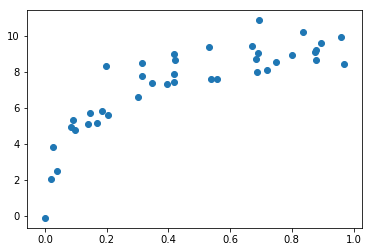

In [15]:
X, target = make_data(40, 1)

# Convert X to 1-Dimensional Data
plt.scatter(X.ravel(), target);

Mean Squared Error: 1.78514645061


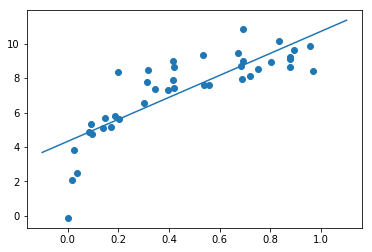

In [16]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]
# Create Line Passing Through Data

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, target)
target_test = model.predict(X_test)

plt.scatter(X.ravel(), target)
plt.plot(X_test.ravel(), target_test)
print ("Mean Squared Error:", metrics.mean_squared_error(model.predict(X), target))
# Unbiased Estimate of Error Variance

A Straight Line Fitted in the Data Might Cause Bias in the and Underfits the Data.
- We Improve this by Creating a More Complicated Model. This is Done by Adding Degrees of Freedom and Computing a Polynomial Regression Over the Inputs
    - Create a PolynomialRegression Estimator

In [17]:
class PolynomialRegression(LinearRegression):
    """Simple Polynomial Regression to 1D data"""
    def __init__(self, degree=1, **kwargs):
        self.degree = degree
        LinearRegression.__init__(self, **kwargs)
        
    def fit(self, X, target):
        if X.shape[1] != 1:
            raise ValueError("Only 1D data valid here")
        Xp = X ** (1 + np.arange(self.degree))
        return LinearRegression.fit(self, Xp, target)
        
    def predict(self, X):
        Xp = X ** (1 + np.arange(self.degree))
        return LinearRegression.predict(self, Xp)

Mean Squared Error: 0.919717192242


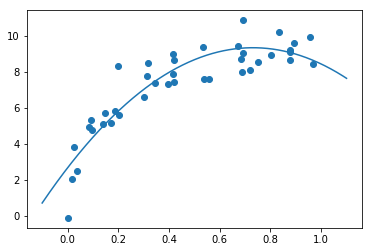

In [18]:
# Fit Quadratic Curve to Formula

model = PolynomialRegression(degree = 2)
model.fit(X, target)
target_test = model.predict(X_test)

plt.scatter(X.ravel(), target)
plt.plot(X_test.ravel(), target_test)
print ("Mean Squared Error:", metrics.mean_squared_error(model.predict(X), target))

#### Example of High Variance Model, Overfitting of Model, and Sensitivity to Noise in Training Data

Mean Squared Error: 0.37555004047


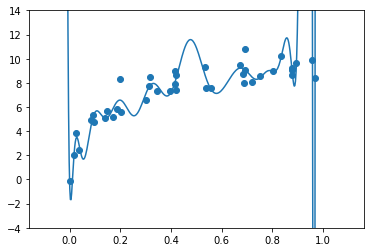

In [19]:
# Using a Higher Degree Polynomial 
model = PolynomialRegression(degree=30)
model.fit(X, target)
target_test = model.predict(X_test)

plt.scatter(X.ravel(), target)
plt.plot(X_test.ravel(), target_test)
plt.ylim(-4, 14)
print ("Mean Squared Error:", metrics.mean_squared_error(model.predict(X), target))

#### Computing Error on Training Data is Not Enough, But Comparing the Training Error and the Validation Error Can Give an Indication of How Well the Data is Being Fitted 

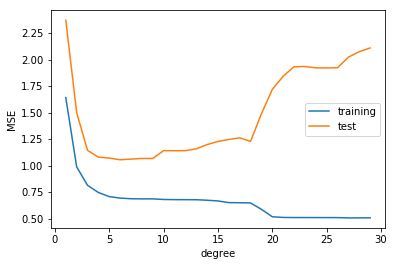

In [20]:
degrees = np.arange(1, 30)

X, target = make_data(100, error=1.0)
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3)

training_error = []
test_error = []
mse = metrics.mean_squared_error

for d in degrees:
    model = PolynomialRegression(d).fit(X_train, target_train)
    training_error.append(mse(model.predict(X_train), target_train))
    test_error.append(mse(model.predict(X_test), target_test))
    
# note that the test error can also be computed via cross-validation
plt.plot(degrees, training_error, label='training')
plt.plot(degrees, test_error, label='test')
plt.legend()
plt.xlabel('degree')
plt.ylabel('MSE');

#### Bias and Variance Plot
- Left of Plot, we have a High-Bias Model Characterized by the Training and Test Data Showing Equally Bad Performance. 
    - Shows That the Model is Under-Fitting the Data Because It Does Poorly on Both Known and Unknown Values
- Right Side of Plot, We Have a High-Variance Model Characterized by Divergence of the Training and Test Data. The Model is Over-fitting the Data. 
    - Particular Noise Distribution of the Input Data Has Too Much Effect on the Result 
    
Optimal Model is Where the Point Where the Test Error is Minimized 

#### Exercise 5 
- Apply Learning Curve to a Decision Tree Regression (sklearn.tree.DecisionTree) 
    - ` max_depth Parameter Controls the Tradeoff Between Bias and Variance` 
    - Generate Dataset with 500 points and Use a Decision Tree Regressor to Explore the Effect of max_depth Parameter on the Bias/Variance Tradeoff and Observe Optimal Value.

/Users/kerrylam/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kerrylam/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kerrylam/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kerrylam/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_

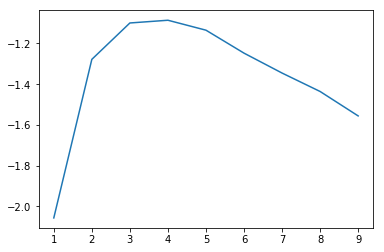

In [21]:
from sklearn.tree import DecisionTreeRegressor
X, target = make_data(500, error=1)

clf = DecisionTreeRegressor()
max_depth = np.arange(1, 10)

grid = GridSearchCV(clf, param_grid={'max_depth': max_depth},
                    scoring='mean_squared_error', cv=5)
grid.fit(X, target)

scores = [g[1] for g in grid.grid_scores_]
plt.plot(max_depth, scores);

#### Quick Exercise 6
- Using Ensemble Methods (sklearn.ensemble.RandomForestRegressor) Uses Multiple Randomized Decision Trees and Averages Their Results. 
- The Ensemble of Estimators Can Often Do Better Than Any Individual Estimator for Data that is Over-fit

/Users/kerrylam/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kerrylam/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kerrylam/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kerrylam/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_

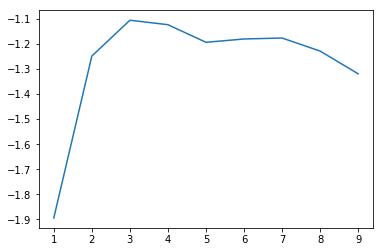

In [22]:
from sklearn.ensemble import RandomForestRegressor
X, target = make_data(200, error=1)

clf = RandomForestRegressor(10)
max_depth = np.arange(1, 10)

grid = GridSearchCV(clf, param_grid={'max_depth': max_depth},
                    scoring='mean_squared_error', cv=5)
grid.fit(X, target)

scores = [g[1] for g in grid.grid_scores_]
plt.plot(max_depth, scores);

#### Illustration of Learning Curves
- The exact turning-point of the tradeoff between bias and variance is highly dependent on the number of training points used.
- The idea is to plot the mean-squared-error for the training and test set as a function of Number of Training Points

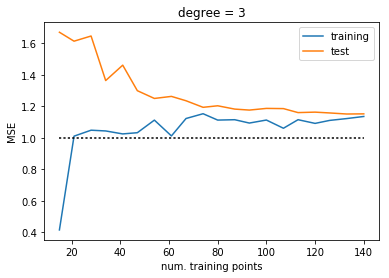

In [23]:
X, target = make_data(200, error=1.0)
degree = 3

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.3)

N_range = np.linspace(15, X_train.shape[0], 20).astype(int)

def plot_learning_curve(degree=3):
    training_error = []
    test_error = []
    mse = metrics.mean_squared_error
    
    for N in N_range:
        XN = X_train[:N]
        yN = target_train[:N]
    
        model = PolynomialRegression(degree).fit(XN, yN)
        training_error.append(mse(model.predict(XN), yN))
        test_error.append(mse(model.predict(X_test), target_test))
      
    plt.plot(N_range, training_error, label='training')
    plt.plot(N_range, test_error, label='test')
    plt.plot(N_range, np.ones_like(N_range), ':k')
    plt.legend()
    plt.title('degree = {0}'.format(degree))
    plt.xlabel('num. training points')
    plt.ylabel('MSE')
    
plot_learning_curve(3)

Depiction of Learning Curve: 
- For very few training points, there is a large separation between the training and test error, which indicates over-fitting. 
- Given the same model, for a large number of training points, the training and testing errors converge, which indicates potential under-fitting.
- If you'd like to reduce the MSE down to the nominal value of 1.0 (which is the magnitude of the scatter we put in when constructing the data), then adding more samples will Never get you there. 
- For $d=3$, we've already converged. What about for $d=1$?

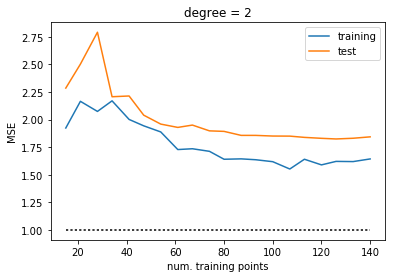

In [24]:
plot_learning_curve(2)

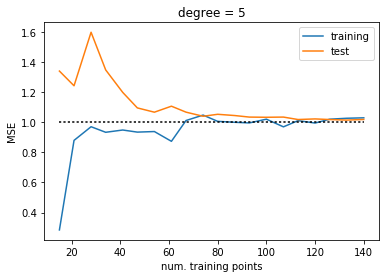

In [25]:
plot_learning_curve(5)

Plot $d = 5$ Converges and Brings the Two Curves Closer Together By Adding More Points
